Selected Parcels: ['C1', 'C2'], Total Value: 110, Total Weight: 30
Time Window Efficiency (DP): 3
Dijkstra from Warehouse: [0, 4, 8, 6]
MST Edges: [(0, 1, 4), (1, 2, 5), (2, 3, 3)] Cost: 12
Brute-force TSP Route: ['Warehouse', 'C1', 'C2', 'C3', 'Warehouse'] Total Distance: 18
Held-Karp (DP) TSP Cost: 18
TSP Execution Times: [(3, 1e-05), (4, 2e-05), (5, 1e-05), (6, 1e-05)]


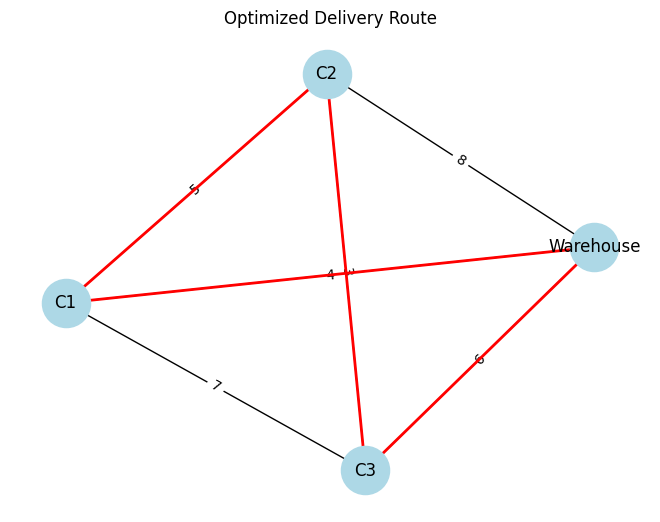

Recurrence-based Total Cost Estimate: 18

--- Summary ---
Used Recurrence, Greedy, DP, Graph & TSP for E-commerce Route Optimization.
Trade-off: Optimal TSP (Exponential) vs. Greedy/DP (Polynomial, faster).


In [3]:
# delivery_route_optimization.py
# Capstone Assignment - Delivery Route Optimization for E-commerce
# BCA (AI&DS) | Design & Analysis of Algorithms Lab
# -------------------------------------------------------------
# Modules
import itertools
import heapq
import networkx as nx
import matplotlib.pyplot as plt
from time import time
!pip install memory_profiler
from memory_profiler import memory_usage

# -------------------------------------------------------------
# 1. INPUT MODELING
locations = ['Warehouse', 'C1', 'C2', 'C3']
distance_matrix = [
    [0, 4, 8, 6],
    [4, 0, 5, 7],
    [8, 5, 0, 3],
    [6, 7, 3, 0]
]

parcels = {
    'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
    'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
    'C3': {'value': 40, 'time': (11, 14), 'weight': 15}
}
vehicle_capacity = 30

# -------------------------------------------------------------
# 2. RECURRENCE-BASED ROUTE COST ESTIMATION
def delivery_cost(i, visited, memo):
    # Base: all visited
    if len(visited) == len(locations):
        return distance_matrix[i][0]
    state = (i, tuple(sorted(visited)))
    if state in memo:
        return memo[state]
    cost = float('inf')
    for j in range(1, len(locations)):
        if j not in visited:
            new_visited = visited | {j}
            new_cost = distance_matrix[i][j] + delivery_cost(j, new_visited, memo)
            cost = min(cost, new_cost)
    memo[state] = cost
    return cost

# -------------------------------------------------------------
# 3. GREEDY + DYNAMIC PROGRAMMING FOR DELIVERY PLANNING
def greedy_parcel_selection(parcels, capacity):
    items = sorted(parcels.items(), key=lambda x: x[1]['value']/x[1]['weight'], reverse=True)
    total_value, total_weight, selected = 0, 0, []
    for c, data in items:
        if total_weight + data['weight'] <= capacity:
            selected.append(c)
            total_value += data['value']
            total_weight += data['weight']
    return selected, total_value, total_weight

def dp_time_window(parcels, start_time=9):
    # Simple DP: maximize deliveries within time windows
    dp = [0]*(len(parcels)+1)
    times = [parcels[p]['time'] for p in parcels]
    for i in range(1, len(parcels)+1):
        early, late = times[i-1]
        dp[i] = max(dp[i-1], (late-early))
    return dp[-1]

# -------------------------------------------------------------
# 4. GRAPH ALGORITHMS: DIJKSTRA & PRIM
def dijkstra(graph, start):
    n = len(graph)
    dist = [float('inf')]*n
    dist[start] = 0
    pq = [(0, start)]
    while pq:
        d, u = heapq.heappop(pq)
        if d > dist[u]:
            continue
        for v in range(n):
            if graph[u][v] > 0:
                nd = d + graph[u][v]
                if nd < dist[v]:
                    dist[v] = nd
                    heapq.heappush(pq, (nd, v))
    return dist

def prim(graph):
    n = len(graph)
    selected = [False]*n
    selected[0] = True
    edges, cost = [], 0
    for _ in range(n-1):
        min_edge = (None, None, float('inf'))
        for i in range(n):
            if selected[i]:
                for j in range(n):
                    if not selected[j] and 0 < graph[i][j] < min_edge[2]:
                        min_edge = (i, j, graph[i][j])
        edges.append(min_edge)
        selected[min_edge[1]] = True
        cost += min_edge[2]
    return edges, cost

# -------------------------------------------------------------
# 5. TSP (BRUTE FORCE & DP)
def tsp_brute_force(locations, distance_matrix):
    n = len(locations)
    indices = list(range(1, n))
    min_cost, best_route = float('inf'), []
    for perm in itertools.permutations(indices):
        cost = distance_matrix[0][perm[0]]
        for i in range(len(perm)-1):
            cost += distance_matrix[perm[i]][perm[i+1]]
        cost += distance_matrix[perm[-1]][0]
        if cost < min_cost:
            min_cost, best_route = cost, perm
    route = [locations[0]] + [locations[i] for i in best_route] + [locations[0]]
    return route, min_cost

def tsp_dp(distance_matrix):
    n = len(distance_matrix)
    dp = [[float('inf')]*(1<<n) for _ in range(n)]
    dp[0][1] = 0
    for mask in range(1<<n):
        for u in range(n):
            if mask & (1<<u):
                for v in range(n):
                    if not (mask & (1<<v)):
                        dp[v][mask | (1<<v)] = min(dp[v][mask | (1<<v)], dp[u][mask] + distance_matrix[u][v])
    return min(dp[i][(1<<n)-1] + distance_matrix[i][0] for i in range(n))

# -------------------------------------------------------------
# 6. PROFILING
def profile_tsp(n):
    times = []
    for k in range(3, n+1):
        locs = locations[:k]
        dist = [r[:k] for r in distance_matrix[:k]]
        start = time()
        tsp_brute_force(locs, dist)
        times.append((k, round(time()-start, 5)))
    return times

# -------------------------------------------------------------
# 7. VISUALIZATION
def visualize_route(route, distance_matrix):
    G = nx.Graph()
    for i in range(len(distance_matrix)):
        for j in range(i+1, len(distance_matrix)):
            if distance_matrix[i][j] > 0:
                G.add_edge(locations[i], locations[j], weight=distance_matrix[i][j])
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1200)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(locations[i], locations[j]): distance_matrix[i][j]
                                                        for i in range(len(distance_matrix))
                                                        for j in range(i+1, len(distance_matrix))})
    path_edges = list(zip(route, route[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2)
    plt.title("Optimized Delivery Route")
    plt.show()

# -------------------------------------------------------------
# 8. MAIN EXECUTION
if __name__ == "__main__":
    # Greedy + DP
    selected, total_value, total_weight = greedy_parcel_selection(parcels, vehicle_capacity)
    print(f"Selected Parcels: {selected}, Total Value: {total_value}, Total Weight: {total_weight}")
    print("Time Window Efficiency (DP):", dp_time_window(parcels))

    # Graph Algorithms
    print("Dijkstra from Warehouse:", dijkstra(distance_matrix, 0))
    mst_edges, mst_cost = prim(distance_matrix)
    print("MST Edges:", mst_edges, "Cost:", mst_cost)

    # TSP
    route, cost = tsp_brute_force(locations, distance_matrix)
    print("Brute-force TSP Route:", route, "Total Distance:", cost)
    print("Held-Karp (DP) TSP Cost:", tsp_dp(distance_matrix))

    # Profiling
    print("TSP Execution Times:", profile_tsp(6))

    # Visualization
    visualize_route(route, distance_matrix)

    # Recurrence-based estimate
    memo = {}
    rec_cost = delivery_cost(0, {0}, memo)
    print("Recurrence-based Total Cost Estimate:", rec_cost)

    # Summary
    print("\n--- Summary ---")
    print("Used Recurrence, Greedy, DP, Graph & TSP for E-commerce Route Optimization.")
    print("Trade-off: Optimal TSP (Exponential) vs. Greedy/DP (Polynomial, faster).")